In [249]:
import json
import cv2 as cv
import pickle as pkl
from typing import Dict, List
import numpy as np
from matplotlib import pyplot as plt
import os, sys
import librosa
import shutil 
import csv

from scipy import stats, spatial, ndimage
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/Gaze_project")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/Gaze_project")
from Signal_processing_utils import intensity_from_signal, pitch_from_signal, sparse_key_smoothing, laplacian_smoothing
from Speech_Data_util import Sentence_word_phone_parser
from prototypes.InputDataStructures import Dietic_Conversation_Gaze_Scene_Info, AgentInfo_time_varying, AgentInfo_final
from prototypes.MVP.MVP_static_saliency_list import ObjectBasedFixSaliency
from prototypes.MVP.MVP_Aversion_saliency_list import AversionSignalDrivenSaliency, CTSAversionSignalDrivenSaliency
from prototypes.MVP.MVP_look_at_point_planner import HabituationBasedPlanner, RandomPlanner, PartnerHabituationPlanner
from prototypes.MVP.MVP_eye_head_driver import HeuristicGazeMotionGenerator
from prototypes.MVP.MVP_Aversion_saliency_list import Base_Static_Saliency_List
from prototypes.EyeCatch.Saccade_model_with_internal_model import *
from prototypes.Gaze_aversion_prior.Heuristic_model import *
from prototypes.Boccignone2020.Gaze_target_planner import Scavenger_based_planner
from prototypes.Boccignone2020.Improved_gaze_target_planner import Scavenger_planner_with_nest, Scavenger_planner_simple 
from prototypes.JaliNeck.JaliNeck import NeckCurve
from prototypes.Gaze_aversion_prior.Ribhav_model import predict_aversion
from prototypes.Gaze_aversion_prior.Evan_model import Aversion111Prior
from prototypes.InputDataStructures import AgentInfo, TurnTakingData
from prototypes.MVP.MVP_gaze_path_planner import Responsive_planner_Differnet_Targets, Responsive_planner_simple, Responsive_planner_no_heuristics, Responsive_planner_no_Gaze_deploy, Responsive_planner_React_to_gaze_no_Gaze_deploy
import pickle
import math
import re
import string
from datetime import datetime, timezone
import scipy.stats as ss
from Signal_processing_utils import interpolate1D, runEuro, pad_arrays
from scipy.interpolate import interp1d
from Geometry_Util import directions_from_rotation_angles

%load_ext autoreload
%autoreload 1

%aimport prototypes.InputDataStructures
%aimport Speech_Data_util
%aimport Signal_processing_utils
%aimport Geometry_Util
%aimport prototypes.MVP.MVP_static_saliency_list
%aimport prototypes.EyeCatch.Saccade_model_with_internal_model
%aimport prototypes.InputDataStructures
%aimport prototypes.Jin2019.EyeHeadDecomposition
%aimport prototypes.Optimization_based_head_eye_seperator.Baseline_optimization
%aimport prototypes.Boccignone2020.Improved_gaze_target_planner
%aimport prototypes.MVP.MVP_gaze_path_planner
%aimport prototypes.JaliNeck.JaliNeck
%aimport prototypes.Gaze_aversion_prior.Evan_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Input Block

In [2]:
# from Video_analysis_utils import get_wav_from_video 
# get_wav_from_video("salty.mp4", "/Volumes/EVAN_DISK/MASC/JALI_gaze/Animations/greenbook_salty")

### You need to make the temp folder yourself before running these

In [3]:
speaker_id = 0
turn_taking_threshold = 2
fps = 25
np.random.seed(speaker_id)

In [4]:
# inputs (for jali laptop)
# input_folder = "/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/"
input_folder = "D:/MASC/shot_processed_dataset/"
input_file = "heat_source_video"
outside_dataset = True
model_location = "C:/Users/evan1/Documents/GitHub/Gaze_project/prototypes/Gaze_aversion_prior/sentence_word_audio_velocity_model"
whisper_location = "C:/Users/evan1/Documents/GitHub/Gaze_project/models"
temp_folder = "D:/MASC/JALI_gaze/Animations/heat" 

In [5]:
# inputs (for desk top at home)
# input_folder = "/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/"
input_folder = "/Volumes/EVAN_DISK/MASC/shot_processed_dataset/"
input_file = "raw_clip"
outside_dataset = True
model_location = "/Users/evanpan/Documents/GitHub/Gaze_project/prototypes/Gaze_aversion_prior/sentence_word_audio_velocity_model"
whisper_location = "/Users/evanpan/Documents/GitHub/Gaze_project/models"

temp_folder = "/Volumes/EVAN_DISK/MASC/JALI_gaze/Animations/green_book_letter" 

In [6]:
# inputs (for desk top at home)
# input_folder = "/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/"
input_folder = "F:/MASC/shot_processed_dataset/"
input_file = "raw_clip"
outside_dataset = True
model_location = "C:/Users/evansamaa/Documents/GitHub/Gaze_project/prototypes/Gaze_aversion_prior/sentence_word_audio_velocity_model"
whisper_location = "C:/Users/evansamaa/Documents/GitHub/Gaze_project/models"
temp_folder = "F:/MASC/JALI_gaze/Animations/green_book_letter" 

## Get all the file paths

In [7]:

input_file_no_space = input_file.replace(" ", "_")
gaze_animation_output_location = os.path.join(*[temp_folder, "outputs"])
try:
    os.mkdir(os.path.join(*[temp_folder, "outputs"]))   
except:
    print("folder already exist")   
try:
    os.mkdir(os.path.join(*[temp_folder, "annotated_scene"]))   
except:
    print("folder already exist")    
# input_file_no_space = "'" + input_file_no_space + "'"
# for both speakers
raw_audio_path = os.path.join(*[temp_folder, input_file_no_space+".wav"]).replace(os.sep, "/")
basic_scene_data_path = "./data/look_at_points/simplest_scene2_less_items.json"
transcription_json_path = os.path.join(*[temp_folder, input_file+"_transcript.json"])
# for the first speaker
speaker_id = 0
praatoutput_path_0 = os.path.join(temp_folder, input_file_no_space+"_{}_PraatOutput.txt".format(speaker_id)).replace(os.sep, "/")
audio_path_0 = os.path.join(*[temp_folder, input_file_no_space+"_{}.wav".format(speaker_id)]).replace(os.sep, "/")
text_file_path_0 = os.path.join(*[temp_folder, input_file_no_space+"_{}.txt".format(speaker_id)]).replace(os.sep, "/")
transcript_file_path_0 = os.path.join(*[temp_folder, input_file+"_transcript.json".format(speaker_id)]).replace(os.sep, "/")
tagged_text_file_path_0 = os.path.join(*[temp_folder, input_file_no_space+"_{}_tagged.txt".format(speaker_id)]).replace(os.sep, "/")
tagged_dialog_file_path_0 = os.path.join(*[temp_folder, input_file+"_dialog_transcript_tagging_0.txt"])
if outside_dataset:
    audio_path_0 = os.path.join(*[temp_folder, input_file_no_space+"_{}.wav".format(speaker_id)]).replace(os.sep, "/")    
# output paths
output_neural_location_0 = os.path.join(*[temp_folder, "outputs", input_file+"_neural_{}.pkl".format(speaker_id)]).replace(os.sep, "/")
# other important input data (such as scene )
annotation_data_path_0= os.path.join(*[temp_folder, "annotated_scene", input_file+"_points_{}.json".format(speaker_id)]).replace(os.sep, "/")
scene_data_path_0 = os.path.join(*[temp_folder, "annotated_scene", input_file+"_scene_{}.json".format(speaker_id)]).replace(os.sep, "/")

# for the first speaker
speaker_id = 1
praatoutput_path_1 = os.path.join(temp_folder, input_file_no_space+"_{}_PraatOutput.txt".format(speaker_id)).replace(os.sep, "/")
audio_path_1 = os.path.join(*[temp_folder, input_file_no_space+"_{}.wav".format(speaker_id)]).replace(os.sep, "/")
text_file_path_1 = os.path.join(*[temp_folder, input_file_no_space+"_{}.txt".format(speaker_id)]).replace(os.sep, "/")
transcript_file_path_1 = os.path.join(*[temp_folder, input_file+"_transcript.json".format(speaker_id)]).replace(os.sep, "/")
tagged_text_file_path_1 = os.path.join(*[temp_folder, input_file_no_space+"_{}_tagged.txt".format(speaker_id)]).replace(os.sep, "/")
tagged_dialog_file_path_1 = os.path.join(*[temp_folder, input_file+"_dialog_transcript_tagging_1.txt"])
if outside_dataset:
    audio_path_1 = os.path.join(*[temp_folder, input_file_no_space+"_{}.wav".format(speaker_id)]).replace(os.sep, "/")    
# output paths
output_neural_location_1 = os.path.join(*[temp_folder, "outputs", input_file+"_neural_{}.pkl".format(speaker_id)]).replace(os.sep, "/")
# other important input data (such as scene )
annotation_data_path_1 = os.path.join(*[temp_folder, "annotated_scene", input_file+"_points_{}.json".format(speaker_id)]).replace(os.sep, "/")
scene_data_path_1 = os.path.join(*[temp_folder, "annotated_scene", input_file+"_scene_{}.json".format(speaker_id)]).replace(os.sep, "/")


folder already exist
folder already exist


## Use deep learning to get aversion probability

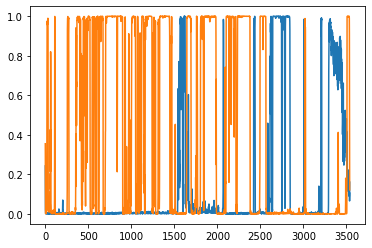

In [8]:
model = Aversion111Prior(model_location, whisper_location)
# for speaker 0 
aversion_probabilities_0, X_0 = model.predict(temp_folder, input_folder, input_file, 0, in_dataset=False)
ts = np.arange(0, aversion_probabilities_0.shape[0]) / fps
# 1 is direct gaze, 0 is aversion, here I want aversion probability
aversion_probability_0 = runEuro(ts, aversion_probabilities_0)[:, 0]
# since the model doesn't give prediction until later in the audio. 
# I will omit the prediction until the mode is fairly certain
for i in range(0, aversion_probability_0.shape[0]):
    if np.abs(aversion_probability_0[i] - 0.5) <= 0.3:
        aversion_probability_0[i] = 0
    else:
        break
aversion_probability_0 = np.where(aversion_probability_0 > 0.5, 1, 0)

aversion_probabilities_1, X_1 = model.predict(temp_folder, input_folder, input_file, 1, in_dataset=False)
ts = np.arange(0, aversion_probabilities_0.shape[0]) / fps
# 1 is direct gaze, 0 is aversion, here I want aversion probability
plt.plot(aversion_probabilities_1[:, 0])
plt.plot(aversion_probabilities_0[:, 0])

aversion_probability_1 = runEuro(ts, aversion_probabilities_1)[:, 0]
# since the model doesn't give prediction until later in the audio. 
# I will omit the prediction until the mode is fairly certain
for i in range(0, aversion_probability_1.shape[0]):
    if np.abs(aversion_probability_1[i] - 0.5) <= 0.3:
        aversion_probability_1[i] = 0
    else:
        break
aversion_probability_1 = np.where(aversion_probability_1 > 0.5, 1, 0)

## Get Voice activity interval

In [9]:
audio_0, sr = librosa.load(audio_path_0)
audio_1, sr = librosa.load(audio_path_1)
audio_0, audio_1 = pad_arrays(audio_0, audio_1)
intensity_0 = intensity_from_signal(audio_0, int(sr/25))
intensity_1 = intensity_from_signal(audio_1, int(sr/25))
acitivity = np.where(intensity_0 > intensity_1, -1, 1)

## Compute Neck Motion (with JaLI)

In [10]:
conversational_neck_0 = NeckCurve(audio_path_0)
jali_neck_output_0 = conversational_neck_0.compute_curve()

conversational_neck_1 = NeckCurve(audio_path_1)
jali_neck_output_1 = conversational_neck_1.compute_curve()

61
61
15
15


## Compute Neck Motion (from CSV)

In [11]:
csv_file_path_0 = os.path.join(*[temp_folder, input_file+"_0_neck.csv"])
csv_file_path_1 = os.path.join(*[temp_folder, input_file+"_1_neck.csv"])

# load the CSV file into a NumPy array
data_0 = np.loadtxt(csv_file_path_0, delimiter=',')
data_1 = np.loadtxt(csv_file_path_0, delimiter=',')

# get neck timing
neck_ts = np.arange(0, data_0.shape[0]) / 20 # 20 fps
neck_ts = neck_ts.flatten().tolist()
# get output
jali_neck_output_0 = [neck_ts, data_0[:, 0].flatten().tolist(), neck_ts, data_0[:, 1].flatten().tolist(), neck_ts, data_0[:, 2].flatten().tolist()]
jali_neck_output_1 = [neck_ts, data_1[:, 0].flatten().tolist(), neck_ts, data_1[:, 1].flatten().tolist(), neck_ts, data_1[:, 2].flatten().tolist()]

FileNotFoundError: F:/MASC/JALI_gaze/Animations/green_book_letter\raw_clip_0_neck.csv not found.

## The following script generate two scene files. Edit and save them in MAYA

In [40]:
if os.path.isfile(scene_data_path_0):
    print("scene file 0 already exist")
else:
    shutil.copy(basic_scene_data_path, scene_data_path_0)
print(scene_data_path_0)
if os.path.isfile(scene_data_path_1):
    print("scene file 1 already exist")
else:
    shutil.copy(basic_scene_data_path, scene_data_path_1)
print(scene_data_path_1)


scene file 0 already exist
F:/MASC/JALI_gaze/Animations/green_book_letter/annotated_scene/raw_clip_scene_0.json
scene file 1 already exist
F:/MASC/JALI_gaze/Animations/green_book_letter/annotated_scene/raw_clip_scene_1.json


# Use deep learning to generate saliency map for the characters when they are speaking

## Obtain the Scene

In [282]:
agentScene0 = AgentInfo_final(scene_data_path_0, wonder=True)
agentScene1 = AgentInfo_final(scene_data_path_1, wonder=True)

## Salinecy Map Object

In [283]:
class Neural_input_Saliency_dynamic_scene(Base_Static_Saliency_List):
    def __init__(self, scene_info: AgentInfo_final, ts, tag_duration, dt=1/24):
        self.scene_info: AgentInfo_final = scene_info
        self._number_of_objects = scene_info.get_all_positions().shape[0]
        self._dt = dt # 100 hz
        self._numb_of_frames = ts.shape[0] # total number of frames
        self.evaluated = False
        self.map = np.zeros((int(self._numb_of_frames), self._number_of_objects))
        self.map_interp = None
        # determine the gaze target over time. 
        self.gaze_target_over_time = []
        self.tag_duration = tag_duration
        self.get_active_object_from_tags()
    def get_index(self, target_name):
        for i in range(0, len(self.scene_info.object_id)):
            if self.scene_info.object_id[i] == target_name:
                return i
        print("Cannot find tagged object in the scene, check the tags in the dialog file.")
        return -1
    def get_active_object_from_tags(self):
        try:
            targets = self.tag_duration["target"]
        except:
            targets = []
        if len(targets) == 0:
            self.gaze_target_over_time = [[0, self.scene_info.other_speaker_id]]
        else:
            self.gaze_target_over_time = [[0, self.scene_info.other_speaker_id]]
            starting_idx = 0
            if targets[0][1] == 0:
                idx = self.get_index(targets[0][0])
                self.gaze_target_over_time = [[0, idx]]
                self.gaze_target_over_time.append([targets[0][2], self.scene_info.other_speaker_id])
                # if the first element is not the other speaker then we initialize the gaze_target_over_time array differently, so we
                # skip the index by one 
                starting_idx = 1
            for i in range(starting_idx, len(targets)):
                idx = self.get_index(targets[i][0])
                self.gaze_target_over_time.append([targets[i][1], idx])
                self.gaze_target_over_time.append([targets[i][2], self.scene_info.other_speaker_id])       
    def get_object_positions(self):
        return self.scene_info.get_all_positions()
    def evaluate_all(self):
        if self.evaluated:
            return self.map
        else:
            self.compute_salience()
            x = np.arange(0, self._numb_of_frames) * self._dt
            self.map_interp = interp1d(x, self.map, axis=0, fill_value="extrapolate", bounds_error=False)
            self.evaluated = True
            return self.map
    def evaluate(self, t):
        if self.evaluated:
            return self.map_interp(t)
        else:
            self.compute_salience()
            x = np.arange(0, self._numb_of_frames) * self._dt
            self.map_interp = interp1d(x, self.map, axis=0, fill_value="extrapolate")
            self.evaluated = True
            return self.map_interp(t)
    def compute_salience(self, aversion_prob_time, aversion_prob_val, interval=True):
        # continue setting salience for all objects
        inteppp = interp1d(aversion_prob_time, aversion_prob_val, bounds_error=False, fill_value="extrapolate")
        for j in range(0, self._numb_of_frames):
            for i in range(0, self._number_of_objects):
                if i < self.scene_info.get_object_positions(coordinate_space="global").shape[0]:
                    self.map[j, i] = self.scene_info.get_interest(i, j * self._dt)
                else:
                    if inteppp(float(j) * self._dt) < 0.3:
                        self.map[j, i] = 0
                    else:
                        self.map[j, i] = 0.1

## Obtain Tagging timing

In [284]:

# Load the transcript list from the JSON file
def get_value_from_time_value_pairs(in_list, t):
    if t > in_list[-1][0]:
        return in_list[-1][1]
    if t <= in_list[0][0]:
        return in_list[0][1]
    for i in range (0, len(in_list)):
        if t > in_list[i][0]:
            return in_list[i][1]
    return -1
def get_beats(audio, sr):
    fps = 50
    audio_energy = intensity_from_signal(audio, int(sr/fps))
    beat_ts = np.arange(0, audio_energy.shape[0]) / fps
    daudio_dt = dx_dt(audio_energy)
    Dm = 0.2
    DM = 0.7
    DM_frame = math.floor(DM / (beat_ts[1] - beat_ts[0]))
    energy_interp = interp1d(beat_ts, audio_energy, bounds_error=False)
    # iterative find audio onset between 0.2 and 0.6 seconds to identify beats
    beats = [[0, False]] # start with a pseudo beat
    for i in range(0, audio_energy.shape[0]):
        if daudio_dt[i] > 5:
            current_beat_t = beat_ts[i]
            if current_beat_t - beat_ts[beats[-1][0]] <= Dm:
                continue
            if current_beat_t - beat_ts[beats[-1][0]] >= DM:
                # these are stored as integer indexes
                start = beats[-1][0]
                end = i
                counter = start + DM_frame
                while counter < end:
                    beats.append([counter, False])
                    counter = counter + DM_frame
            beats.append([i, True])
    beats_arr = []
    for i in range(0, len(beats)):
        if beats[i][1]:
            beats_arr.append([beat_ts[beats[i][0]], audio_energy[beats[i][0]]])
    beats_arr = np.array(beats_arr)
    return beats_arr
def get_tags(transcript_file_path, tagged_text_file_path, speaker_id):
    with open(transcript_file_path, 'r') as f:
        if speaker_id == 0:
            transcript_list = json.load(f)["self"]
        else:
            transcript_list = json.load(f)["other"]

    # Load the transcript text file
    with open(tagged_text_file_path, 'r') as f:
        transcript = f.read()
    transcript_list.append({"text":"EOH", "start":transcript_list[-1]["end"]})
    word_list = [word["text"] for word in transcript_list]
    translator = str.maketrans('', '', string.punctuation.replace('<', '').replace('>', '').replace('-', '').replace('_', '').replace("'", '').replace("/", '').replace("@", ''))
    # Remove all punctuation except < and > from the input string using the translation table
    word_list = [word.translate(translator) for word in word_list]
    transcript = transcript.translate(translator)
    transcript = transcript.split(" ")
    transcript = [s for s in transcript if s != ""]
    transcript.append("EOT")
    i = 0
    j = 0
    tag_durations = {}
    while i < len(transcript):
        if transcript[i] == word_list[j]:
            i += 1
            j += 1
        else:
            # if this is a starting tag
            if transcript[i][-2:] != "/>":
                active_tag = transcript[i][1:-1]
                active_tag_interval = [j]
                # iterate through the list to find the matching tag
                ii = i + 1
                jj = j
                while ii < len(transcript):
                    if jj < len(word_list) and transcript[ii] == word_list[jj]:
                        ii += 1
                        jj += 1
                    else:
                        # if we have foudn the end tag
                        if transcript[ii][-2:] == "/>" and transcript[ii][1:-2] == active_tag:
                            active_tag_interval.append(jj)
                            active_tag_interval[0] = transcript_list[active_tag_interval[0]]["start"]
                            active_tag_interval[1] = transcript_list[active_tag_interval[1]]["start"]
                            print(active_tag)
                            if active_tag[0:2] != "at":
                                try:
                                    tag_durations[active_tag].append(active_tag_interval.copy())
                                except:
                                    tag_durations[active_tag] = [active_tag_interval.copy()]
                            else:
                                try:
                                    tag_durations["target"].append([active_tag[2:], active_tag_interval[0], active_tag_interval[1]])
                                except:
                                    tag_durations["target"] = [[active_tag[2:], active_tag_interval[0], active_tag_interval[1]]]          
                            break
                        else:
                            ii+=2
                            jj+=1
            i += 2
            j += 1
    return tag_durations
def apply_stare_tags(tag_durations, ts, aversion_probability):
    try:
        stare_intervals = tag_durations["stare"]
        stare_intervals_index_sets = []
        for i in range(0, len(stare_intervals)):
            index_set = []
            for t in range(ts.shape[0]):
                if ts[t] >= stare_intervals[i][0] and len(index_set) == 0:
                    index_set.append(t)
                if ts[t] >= stare_intervals[i][1]:
                    index_set.append(t)
                    break
            stare_intervals_index_sets.append(index_set)

        for i in range(len(stare_intervals_index_sets)):
            aversion_probability[stare_intervals_index_sets[i][0]:stare_intervals_index_sets[i][1]] = 0
    except:
        pass
    return aversion_probability
def apply_directional_tag(tag_durations, aversion_saliency):
    tag_directions = ["up", "down", "left", "right"]
    for dire in tag_directions:
        look_up_intervals = []
        try:
            look_up_intervals = tag_durations[dire]
        except:
            continue
        look_up_intervals_index_sets = []
        for i in range(0, len(look_up_intervals)):
            index_set = []
            for t in range(ts.shape[0]):
                if ts[t] >= look_up_intervals[i][0] and len(index_set) == 0:
                    index_set.append(t)
                if ts[t] >= look_up_intervals[i][1]:
                    index_set.append(t)
                    break
            look_up_intervals_index_sets.append(index_set)
        objects_positions = aversion_saliency.get_object_positions()
        active_object_overtime = aversion_saliency.gaze_target_over_time
        for i in range(len(look_up_intervals_index_sets)):
            for j in range(look_up_intervals_index_sets[i][0], look_up_intervals_index_sets[i][1]):
                t = j * aversion_saliency._dt
                aversion_saliency.scene_info.active_object_id = get_value_from_time_value_pairs(active_object_overtime, t)
                if dire == "up":
                    above = np.where(objects_positions[:, 1] >= objects_positions[aversion_saliency.scene_info.active_object_id, 1], 1, 0)
                    above[aversion_saliency.scene_info.active_object_id] = 1
                elif dire == "down":
                    above = np.where(objects_positions[:, 1] <= objects_positions[aversion_saliency.scene_info.active_object_id, 1], 1, 0)
                    above[aversion_saliency.scene_info.active_object_id] = 1
                elif dire == "left":
                    above = np.where(objects_positions[:, 0] <= objects_positions[aversion_saliency.scene_info.active_object_id, 0], 1, 0)
                    above[aversion_saliency.scene_info.active_object_id] = 1
                elif dire == "right":
                    above = np.where(objects_positions[:, 0] >= objects_positions[aversion_saliency.scene_info.active_object_id, 0], 1, 0)
                    above[aversion_saliency.scene_info.active_object_id] = 1
                    
                # mask = np.tile(np.expand_dims(above, axis=0), [look_up_intervals_index_sets[i][1] - look_up_intervals_index_sets[i][0], 1])
                mask = above
                aversion_saliency.map[j] *= mask
    return aversion_saliency
def get_tags_dialog_format(transcript_file_path, tagged_dialogue_file_path, speaker_id):
    with open(transcript_file_path, 'r') as f:
        if speaker_id == 0:
            transcript_list = json.load(f)["self"]
        else:
            transcript_list = json.load(f)["other"]

    # Load the transcript text file
    with open(tagged_dialogue_file_path, 'r') as f:
        transcript = f.read()
    transcript_lines = transcript.split("\n")
    # keep only the speech of matching speaker_id
    speaker_script = []
    for l in range(0, len(transcript_lines)):
        speaker, text = transcript_lines[l].split(":")
        if speaker_id == int(speaker[-1]):
            speaker_script.append(text.strip())
    transcript = " ".join(speaker_script)
    transcript_list.append({"text":"EOH", "start":transcript_list[-1]["end"]})
    word_list = [word["text"] for word in transcript_list]
    translator = str.maketrans('', '', string.punctuation.replace('<', '').replace('>', '').replace('-', '').replace('_', '').replace("'", '').replace("/", '').replace("@", ''))
    # Remove all punctuation except < and > from the input string using the translation table
    word_list = [word.translate(translator) for word in word_list]
    transcript = transcript.translate(translator)
    transcript = transcript.split(" ")
    transcript = [s for s in transcript if s != ""]
    transcript.append("EOT")
    i = 0
    j = 0
    tag_durations = {}
    while i < len(transcript):
        if transcript[i] == word_list[j]:
            i += 1
            j += 1
        else:
            # if this is a starting tag
            if transcript[i][-2:] != "/>":
                active_tag = transcript[i][1:-1]
                active_tag_interval = [j]
                # iterate through the list to find the matching tag
                ii = i + 1
                jj = j
                while ii < len(transcript):
                    if jj < len(word_list) and transcript[ii] == word_list[jj]:
                        ii += 1
                        jj += 1
                    else:
                        # if we have foudn the end tag
                        if transcript[ii][-2:] == "/>" and transcript[ii][1:-2] == active_tag:
                            active_tag_interval.append(jj)
                            active_tag_interval[0] = transcript_list[active_tag_interval[0]]["start"]
                            active_tag_interval[1] = transcript_list[active_tag_interval[1]]["start"]
                            if active_tag[0] != "@":
                                try:
                                    tag_durations[active_tag].append(active_tag_interval.copy())
                                except:
                                    tag_durations[active_tag] = [active_tag_interval.copy()]
                            else:
                                try:
                                    tag_durations["target"].append([active_tag[1:], active_tag_interval[0], active_tag_interval[1]])
                                except:
                                    tag_durations["target"] = [[active_tag[1:], active_tag_interval[0], active_tag_interval[1]]]          
                            break
                        else:
                            ii+=2
                            jj+=1
            i += 2
            j += 1
    return tag_durations
# tag_durations_0 = get_tags(transcript_file_path_0, tagged_text_file_path_0, 0)
# tag_durations_1 = get_tags(transcript_file_path_1, tagged_text_file_path_1, 1)
tag_durations_0 = get_tags_dialog_format(transcript_file_path_1, tagged_dialog_file_path_0, 0)
tag_durations_1 = get_tags_dialog_format(transcript_file_path_1, tagged_dialog_file_path_0, 1)
aversion_probability_0 = apply_stare_tags(tag_durations_0, ts, aversion_probability_0)
aversion_probability_1 = apply_stare_tags(tag_durations_1, ts, aversion_probability_1)
sementic_script_0 = Sentence_word_phone_parser(praatoutput_path_0, praatoutput_path_0)
sementic_script_0.get_turns(turn_taking_threshold)
sementic_script_1 = Sentence_word_phone_parser(praatoutput_path_1, praatoutput_path_1)
sementic_script_1.get_turns(turn_taking_threshold)

aversion_saliency_0 = Neural_input_Saliency_dynamic_scene(agentScene0, ts, tag_durations_0, 1.0/fps)
aversion_saliency_0.compute_salience(ts, aversion_probability_0)
aversion_saliency_0 = apply_directional_tag(tag_durations_0, aversion_saliency_0)
aversion_saliency_1 = Neural_input_Saliency_dynamic_scene(agentScene1, ts, tag_durations_1, 1.0/fps)
aversion_saliency_1.compute_salience(ts, aversion_probability_1)
aversion_saliency_1 = apply_directional_tag(tag_durations_1, aversion_saliency_1)

beats_0 = get_beats(audio_0, sr)[:, 0]
beats_1 = get_beats(audio_1, sr)[:, 0]

# Compute Gaze Targets

In [285]:
planner0 = Responsive_planner_Differnet_Targets([aversion_saliency_0], agentScene0, aversion_probability_0, aversion_probability_1, acitivity, beats_0, min_saccade_time_consecutive=0)
planner1 = Responsive_planner_Differnet_Targets([aversion_saliency_1], agentScene1, aversion_probability_1, aversion_probability_0, -acitivity, beats_1, min_saccade_time_consecutive=0)
output_times_0, output_targets_0 = planner0.compute()
output_times_1, output_targets_1 = planner1.compute()
print(output_targets_0)

[1, 4, 1, 4, 1, 0, 1, 4, 1, 0, 1, 0, 1, 0, 1, 0, 3, 1, 4, 1, 3, 1, 1, 0, 1, 4, 1, 0, 1, 4, 2, 1, 0, 1, 2, 1, 1]


## Output Gaze motion

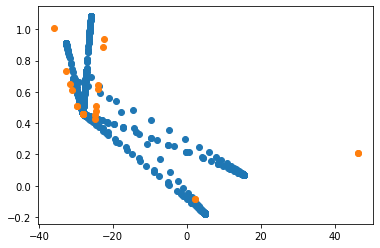

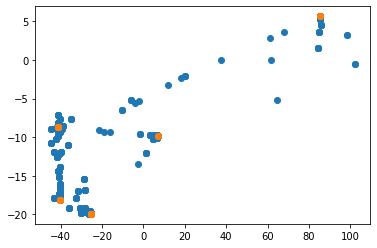

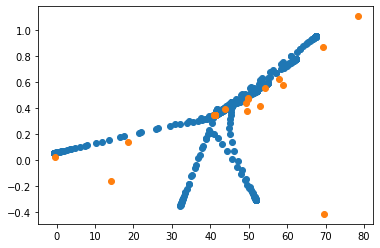

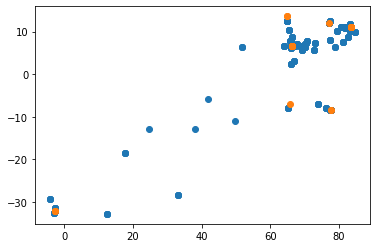

In [287]:
#get the output_targets_positions from the scene
def output_files(agentScene, output_targets, output_times, jali_neck_output, output_neural_location, gaze_target_over_time):
    output_target_positions = []
    posssss = agentScene.get_all_positions(coordinate_space="local")
    for i in output_targets:
        output_target_positions.append(posssss[i])
    internal_model = InternalModelCenterBias_dynamic_scene(agentScene)
    # the good model
    generator = SacccadeGenerator_dynamic_scene(output_times, output_target_positions, output_targets, internal_model, gaze_target_over_time, dt=1/fps)
    ek, hk, micro_saccade = generator.compute()
    display_targetss(generator.head_positions)
    display_targetss(generator.target_positions_head, label="head_look_at")
    plt.show()
    display_targetss(generator.gaze_positions)
    display_targetss(generator.target_gaze_intervals_pos, label="head_look_at")
    plt.show()
    blend_weight = []
    for i in range(1, len(hk[0])-1):
        velocity = math.sqrt((hk[0][i][1]-hk[0][i-1][1])**2 + (hk[0][i-1][2]-hk[0][i][2])**2)
        blend_weight.append([hk[0][i][0], 1 - min(1, velocity/0.75)])
    out = {"eye_frames": ek,
            "head_frames": hk,
            "micro_saccade": micro_saccade,
            "other_neck": jali_neck_output,
            "envelope":[]}
            # "output_times": output_times, 
            # "output_targets": output_targets
    with open(output_neural_location, 'wb') as f:
        pickle.dump(out, f, protocol=2)
output_files(agentScene0, output_targets_0, output_times_0, jali_neck_output_0, output_neural_location_0, aversion_saliency_0.gaze_target_over_time)
output_files(agentScene1, output_targets_1, output_times_1, jali_neck_output_1, output_neural_location_1, aversion_saliency_1.gaze_target_over_time)
